# Image Matching and Homography Estimation with OpenCV and LightGlue

**LightGlue Repository:** https://github.com/cvg/LightGlue

In [15]:
### Uncomment and run the bottom two lines to install LightGlue!
### Restart kernel ("Run" -> "Restart & clear cell outputs") after installation!

#!git clone https://github.com/cvg/LightGlue.git 
#!python -m pip install -e LightGlue/

In [16]:
import os
import cv2 
import json
import torch
import numpy as np
import matplotlib.pyplot as plt

from lightglue import viz2d
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd, numpy_image_to_torch
import CSRansac

In [17]:
class cfg:
    img0 = "img0.png"
    img1 = "img1.png"
    
    size = (320, 240)
    interpolation = cv2.INTER_AREA
    
    lightglue = {
        "extractor": "SuperPoint", # SuperPoint, DISK
        "device": "cuda", # cpu, cuda
        "max_kpts": 2048,
        "homography": {
            "method": cv2.RANSAC,
            "ransacReprojThreshold": 3.0
        }
    }

In [18]:
def load_img(file, size, interpolation):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size, interpolation=interpolation)
    return img


def get_homography(src_pts, dst_pts, method, ransacReprojThreshold):
    homography, mask = cv2.findHomography(
        src_pts, 
        dst_pts, 
        method=method, 
        ransacReprojThreshold=ransacReprojThreshold
    )
    return homography, mask

def plot_two_imgs(img0, img1, title=""):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img0)
    axes[0].axis("off")
    axes[0].set_title(title)
    axes[1].imshow(img1)
    axes[1].axis("off")
    axes[1].set_title(title)
    plt.show()


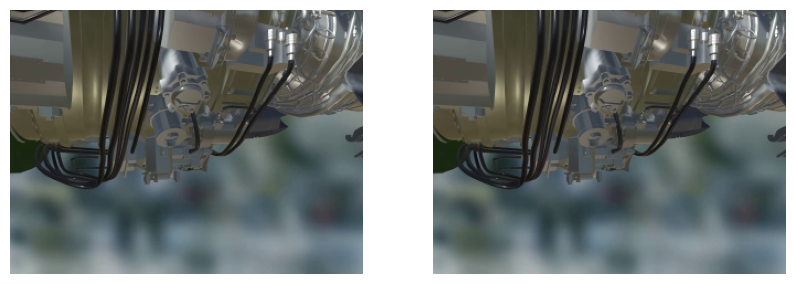

In [19]:
img0 = load_img(cfg.img0, size=cfg.size, interpolation=cfg.interpolation)
img1 = load_img(cfg.img1, size=cfg.size, interpolation=cfg.interpolation)

plot_two_imgs(img0, img1)

## LightGlue

In [20]:
def preprocess_lightglue(img):
    img = numpy_image_to_torch(img)
    return img


def match_lightglue(img0, img1, cfg):
    img0 = load_image(img0)
    img1 = load_image(img1)
    
    if cfg["extractor"] == "SuperPoint":
        extractor = SuperPoint(max_num_keypoints=cfg["max_kpts"]).eval().to(cfg["device"])
        matcher = LightGlue(features='superpoint').eval().to(cfg["device"])

    # if cfg["extractor"] == "DISK":
    #     extractor = DISK(max_num_keypoints=cfg["max_kpts"]).eval().to(cfg["device"])  # load the extractor
    #     matcher = LightGlue(features='disk').eval().to(cfg["device"])  # load the matcher

    # extract local features
    feats0 = extractor.extract(img0.to(cfg["device"]))  # auto-resize the image, disable with resize=None
    feats1 = extractor.extract(img1.to(cfg["device"]))
    
    # match the features
    matches01 = matcher({'image0': feats0, 'image1': feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension
    
    # get results
    kpts0 = feats0["keypoints"]
    kpts1 = feats1["keypoints"]
    matches = matches01['matches']  # indices with shape (K,2)
    points0 = kpts0[matches[..., 0]]  # coordinates in img0, shape (K,2)
    points1 = kpts1[matches[..., 1]]  # coordinates in img1, shape (K,2)
        
    return {
        "points0": points0,
        "points1": points1,
        "matches01": matches01, 
        "matches": matches,
        "kpts0": kpts0,
        "kpts1": kpts1,
        "img0": img0,
        "img1": img1
    }


def visualize_lightglue(img0, img1, points0, points1, kpts0, kpts1, matches01, **kwargs):
    axes = viz2d.plot_images([img0, img1])
    viz2d.plot_matches(points0, points1, color='lime', lw=0.2)
    viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

    kpc0, kpc1 = viz2d.cm_prune(matches01['prune0']), viz2d.cm_prune(matches01['prune1'])
    viz2d.plot_images([img0, img1])
    viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

CPU times: total: 2.2 s
Wall time: 522 ms


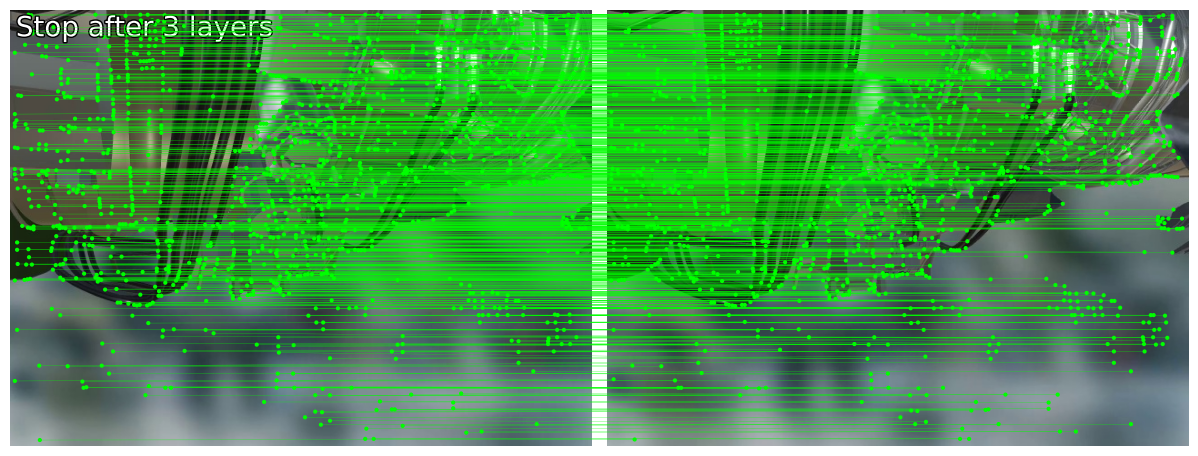

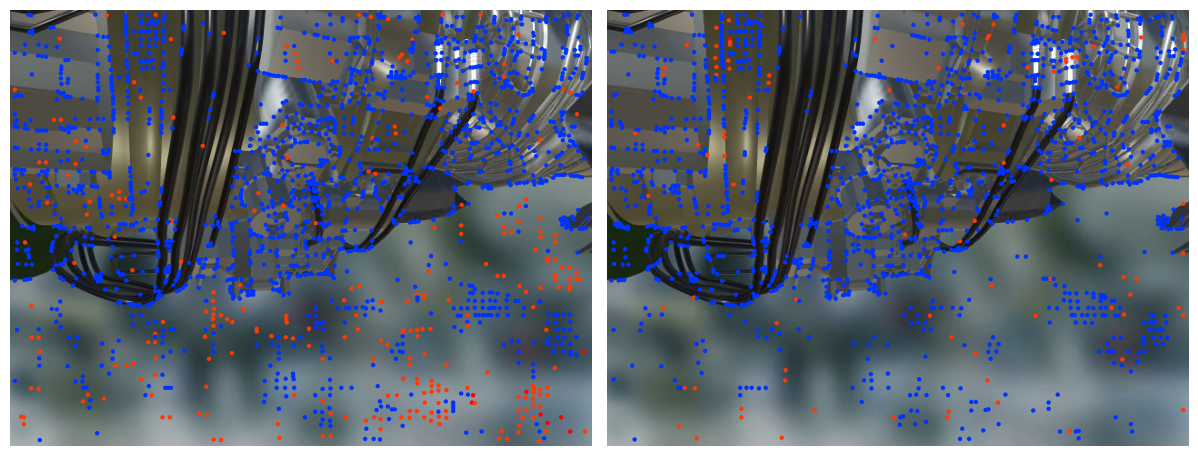

In [21]:
# LightGlue
%time results_lightglue = match_lightglue(cfg.img0, cfg.img1, cfg.lightglue)
visualize_lightglue(**results_lightglue)

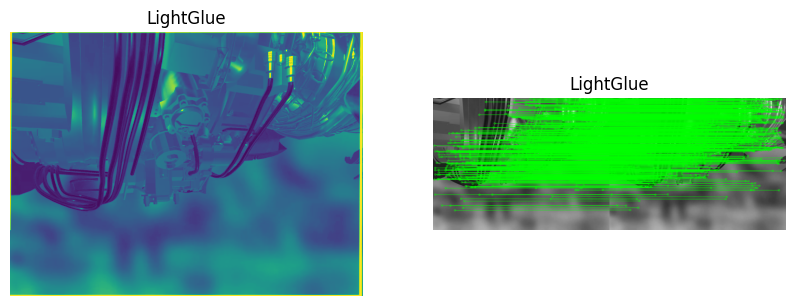

In [22]:
def lightglue2opencv(points0, points1, matches, kpts0, kpts1, img0, img1, **kwargs):
    return {
        "src_pts": points0.cpu().numpy().reshape(-1, 1, 2),
        "dst_pts": points1.cpu().numpy().reshape(-1, 1, 2),
        "kp0": cv2.KeyPoint_convert(kpts0.cpu().numpy()),
        "kp1": cv2.KeyPoint_convert(kpts1.cpu().numpy()),
        "matches": tuple(
            cv2.DMatch(matches[i][0].item(), matches[i][1].item(), 0.) 
            for i in range(matches.shape[0])
        ),
        "img0": cv2.cvtColor((255 * img0).cpu().numpy().astype(np.uint8).transpose(1, 2, 0), cv2.COLOR_RGB2GRAY),
        "img1": cv2.cvtColor((255 * img1).cpu().numpy().astype(np.uint8).transpose(1, 2, 0), cv2.COLOR_RGB2GRAY)
    }
    
    
def visualize_opencv(src_pts, dst_pts, kp0, kp1, matches, img0, img1, cfg, title="OpenCV", **kwargs):   
    homography, mask = get_homography(src_pts, dst_pts, cfg["method"], cfg["ransacReprojThreshold"])
    matches_mask = mask.ravel().tolist()
    
    # visualize mapping
    h, w = img0.shape[:2]
    pts = np.float32([[0, 0],[0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, homography)
    vis_mapping = cv2.polylines(img1.copy(), [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
    
    # visualize matches
    draw_params = dict(
        matchColor = (0, 255, 0), # draw matches in green color
        singlePointColor = None,
        matchesMask = matches_mask, # draw only inliers
        flags = 2
    )
    vis_matches = cv2.drawMatches(img0, kp0, img1, kp1, matches, None, **draw_params)
    
    # plot visualizations
    plot_two_imgs(vis_mapping, vis_matches, title=title)
    
    return homography

def change_coord(homography_lightglue, x, y):
    H = homography_lightglue
    source_coord = np.array([x, y, 1], dtype='float32')
    transformed_coord = np.dot(H, source_coord.T)
    transformed_coord = transformed_coord / transformed_coord[2] # 정규 좌표로 변환
    transformed_coord = transformed_coord.astype('int32')
    transformed_coord_2d = transformed_coord[:2].tolist()
    
    return transformed_coord_2d


results_lightglue_opencv = lightglue2opencv(**results_lightglue)
homography_lightglue = visualize_opencv(**results_lightglue_opencv, cfg=cfg.lightglue["homography"], title="LightGlue")

## Compare Homography Matrices

test

In [23]:
homography_lightglue = homography_lightglue.round(2)
print("Lightglue:\n", homography_lightglue)

img0 = cv2.imread("img0.png")
img1 = cv2.imread("img1.png")
#json 파일 읽기
with open('anno1.json', 'r') as f:
    json_data = json.load(f)

Lightglue:
 [[ 1.   -0.01  1.9 ]
 [ 0.    1.   -0.71]
 [ 0.   -0.    1.  ]]


In [24]:
# coord = json_data["targetAnnotation"]
# x = float(coord[0])
# y = float(coord[1])
# width = img0.shape[1]
# height = img0.shape[0]
# x = int(x * width)
# y = int(y * height)
x = 637 // 2
y = 367 // 2
#x, y좌표에 점 찍기
cv2.circle(img0, (x, y), 5, (0, 0, 255), -1)
cv2.imshow("img0", img0)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [25]:
coord = (x, y)
transformed_coord_2d = change_coord(homography_lightglue, coord)
print(transformed_coord_2d)
# #img1 = cv2.resize(img1, (640, 480))
# #x, y좌표에 점 찍기
# cv2.circle(img1, transformed_coord_2d, 5, (0, 0, 255), -1)
# cv2.imshow("img1", img1)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

TypeError: change_coord() missing 1 required positional argument: 'y'

In [26]:
transformed_img1 = cv2.warpPerspective(img1, homography_lightglue, (img0.shape[1], img0.shape[0]))

cv2.circle(transformed_img1, transformed_coord_2d, 5, (0, 255, 0), -1)
cv2.imshow("transformed", transformed_img1)
# #사진 저장
# cv2.imwrite("transformed_img1.png", transformed_img1)
cv2.waitKey(0)
cv2.destroyAllWindows()

NameError: name 'transformed_coord_2d' is not defined

In [ ]:
#동영상에서 각 프레임을 이미지 파일로 저장하는 코드

# 동영상 파일 로드
video = cv2.VideoCapture('demo_video.mp4')

# 프레임 카운터 초기화
frame_count = 0

while True:
    # 동영상에서 프레임을 읽음
    ret, frame = video.read()
    if not ret:
        break  # 동영상 끝에 도달하면 중단
    
    # 프레임을 이미지 파일로 저장
    frame_filename = os.path.join('video', f'frame_{frame_count:04d}.jpg')
    frame = cv2.resize(frame, (640, 480))
    cv2.imwrite(frame_filename, frame)
    
    frame_count += 1

# 자원 해제
video.release()


In [ ]:
# 이미지 파일들이 저장된 폴더
folder = 'video'


images = []
# 폴더 내의 파일들을 읽어서 리스트에 저장
for name in os.listdir(folder):
    filename = os.path.join(folder, name)
    if os.path.isfile(filename):
        images.append(filename)
        
len(images)

368

In [ ]:
target_keypoint = results_lightglue["points0"].cpu().numpy()
frame_keypoint = results_lightglue["points1"].cpu().numpy()
print(target_keypoint.shape, frame_keypoint.shape)

(1277, 2) (1277, 2)


In [ ]:
# #인접한 프레임들끼리의 좌표 변환
# len_img = len(images)
# x = 637 // 2
# y = 367 // 2

# coord_list = []

# for i in range(len_img):
#     if i != len_img - 1:
#         img0 = images[i]
#         img1 = images[i+1]
        
#         # LightGlue
#         results_lightglue = match_lightglue(img0, img1, cfg.lightglue)
#         results_lightglue_opencv = lightglue2opencv(**results_lightglue)
#         src_pts = results_lightglue_opencv["src_pts"]
#         dst_pts = results_lightglue_opencv["dst_pts"]
        
#         homography, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 3.0)
#         progected_pts = cv2.perspectiveTransform(np.array([[[x, y]]]).astype(np.float32), homography)
#         _coord = change_coord(homography, x, y)
#         x = _coord[0]
#         y = _coord[1]
        
#         coord_list.append(_coord)

In [ ]:
#원본 이미지를 기준으로 좌표 변환
len_img = len(images)
x = 637 // 4
y = 367 // 4

coord_list = []
img0 = images[0]

for i in range(len_img):
    if i != len_img - 1:
        img1 = images[i+1]
        
        # LightGlue
        results_lightglue = match_lightglue(img0, img1, cfg.lightglue)
        results_lightglue_opencv = lightglue2opencv(**results_lightglue)
        target_keypoint = results_lightglue["points0"].cpu().numpy()
        frame_keypoint = results_lightglue["points1"].cpu().numpy()
        src_pts = results_lightglue_opencv["src_pts"]
        dst_pts = results_lightglue_opencv["dst_pts"]
        
        homography, _ = CSRansac.csransac(target_keypoint, frame_keypoint)
        #homography, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 3.0)
        progected_pts = cv2.perspectiveTransform(np.array([[[x, y]]]).astype(np.float32), homography)
        _coord = change_coord(homography, x, y)
        
        coord_list.append(_coord)

IndexError: list assignment index out of range

In [ ]:
# 폴더 경로 설정
folder = 'video'

# 동영상 저장 경로 설정
output_video_path = 'result2.mp4'

# 동영상 속성 설정
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # 코덱 설정 (XVID를 사용하면 AVI 형식으로 저장)
fps = 30.0  # 초당 프레임 수
frame_width = 640  # 프레임 너비
frame_height = 480  # 프레임 높이

out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

x = 637 // 2
y = 367 // 2

i = 0
for name in os.listdir(folder):
    img = cv2.imread(os.path.join(folder, name))
    if i == 0:
        cv2.circle(img, (x, y), 3, (0, 0, 255), -1)
    elif i == len_img - 1:
        break
    else:
        x = coord_list[i][0]
        y = coord_list[i][1]
        cv2.circle(img, (x, y), 3, (0, 0, 255), -1)

    i = i + 1
    
    # 프레임을 동영상에 추가
    out.write(img)

# 동영상 저장 종료
out.release()


IndexError: list index out of range